# Gas consumption data

Import the right modules

In [1]:
# For arrays and other numerical operations (any function from this module can be used by typing np.FunctioName)
import numpy as np
# Import specifically the inverse function and the block diagonal function which can be used without prefix
from numpy.linalg import inv
from scipy.linalg import block_diag
from numpy.linalg import cholesky
import statsmodels.api as sm
from sklearn.neighbors import KernelDensity

# For plotting
import matplotlib.pyplot as plt
import pylab

Define the 1-dimensional normal distribution $\mathcal{N}(\mu, \sigma^2)$

In [2]:
def normal_pdf(x, mu, var):
    return np.exp(-np.power(x-mu, 2)/(2*var)) / np.sqrt(2 * np.pi * var)

Define the general Kalman filter

In [3]:
def Kalman_filter(y, m0, P0, F, H, U, V, n, xdim, delta):
    # y       data array (dim d' x N with N the total number of data points)
    # m0      prior mean (dim d)
    # P0      prior variance (dim d x d)
    # F       transition matrix (dim d x d)
    # H       observation matrix (dim d' x d)
    # U       transition noise covariance (dim d x d)
    # V       observatiion noise variance (dim d' x d')
    # n       number of time steps to be processed
    # xdim    dimension of the state (same as d)
    # delta   number of predictive time steps (last observation used n - delta - 1)
    
    mu = np.zeros((xdim, n))
    Pu = np.zeros((xdim, xdim, n))
    mp = np.zeros((xdim, n))
    Pp = np.zeros((xdim, xdim, n))
    mp[:, 0] = m0
    Pp[:, :, 0] = P0
    marg_like = np.zeros(n)
    err = np.zeros(n)
    for k in range(n):
        z = y[:, k] - np.matmul(H, mp[:, k])
        S = np.matmul(np.matmul(H, Pp[:, :, k]), H.transpose()) + V
        marg_like[k] = normal_pdf(z, 0.0, S)
        err[k] = z / np.sqrt(S)
        if k < n - delta:
            # Update
            K = np.matmul(np.matmul(Pp[:, :, k], H.transpose()), inv(S))
            mu[:, k] = mp[:, k] + np.matmul(K, z)
            Pu[:, :, k] = np.matmul(np.eye(xdim) - np.matmul(K, H), Pp[:, :, k])
        else:
            mu[:, k] = mp[:, k]
            Pu[:, :, k] = Pp[:, :, k]
        
        if k < n-1:
            # Prediction
            mp[:, k+1] = np.matmul(F, mu[:, k])
            Pp[:, :, k+1] = np.matmul(np.matmul(F, Pu[:, :, k]), F.transpose()) + U
    return mp, Pp, mu, Pu, marg_like, err

Function performing model comparison, i.e. computing $L_k$ and $\delta^*_k$

In [4]:
def model_comparison(Bayes_factor, n):
    Lk = np.zeros(n)
    run_length = np.zeros(n)
    Lk[0] = Bayes_factor[0]
    run_length[0] = 1
    for k in range(1,n):
        Lk[k] = Bayes_factor[k] * min(1, Lk[k-1])
        if (Lk[k-1] < 1):
            run_length[k] = run_length[k-1] + 1
        else:
            run_length[k] = 1
    return Lk, run_length

Kernel density estimation

In [5]:
def plot_density(err, bandwidth):
    err_tab = err[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(err_tab)
    X_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    plt.plot(X_plot[:, 0], np.exp(log_dens))

Rotation matrix $R(\omega)$

In [6]:
def rotation_mat(omega):
    cw = np.cos(omega)
    sw = np.sin(omega)
    return np.array([[cw, sw],[-sw, cw]])

## The data

In [7]:
# Array of data (rows are months (January to December) and columns are years)
data = np.array([[0, 8.3, 7.7, 8.5, 7.7, 8.8],
                 [0, 7.2, 7.7, 7.9, 9.0, 8.7],
                 [0, 9.2, 8.9, 8.9, 9.0, 10.1],
                 [0, 5.5, 5.7, 5.4, 6.5, 6.1],
                 [4.9, 4.7, 5.0, 4.4, 5.1, 5.0],
                 [4.5, 4.4, 4.5, 4.0, 4.3, 4.5],
                 [3.1, 3.4, 3.3, 3.0, 2.7, 3.1],
                 [3.1, 2.8, 2.8, 3.1, 2.8, 2.9],
                 [4.6, 4.0, 4.0, 4.4, 4.6, 4.8],
                 [4.8, 5.1, 5.6, 5.5, 5.5, 0],
                 [6.7, 6.5, 6.6, 6.5, 6.9, 0],
                [8.6, 9.2, 10.3, 10.1, 9.5, 0]])

In [8]:
# Reshape the data into one row vector and remove zeros at the start and end
y = (data.T).reshape(1,72)[:, 4:-3]

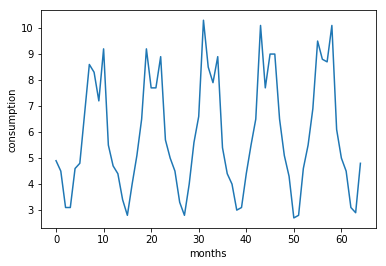

In [9]:
# Plot the data
plt.plot(y[0, :])
plt.xlabel('months')
plt.ylabel('consumption');

In [10]:
# All data points are considered for filtering
n = len(y[0, :])

# The period is 12 months
p = 12
omega = 2*np.pi / p

# Observation noise (we assume the observations are rather accurate)
V = 0.01 * np.eye(1)

## A simple model

In [29]:
# Superposition of a first-order model and a simple Fourier-form seasonal model
F = block_diag(1, rotation_mat(omega))
H = np.array([[1, 1, 0]])

# Uninformative prior (large covariance)
m0 = np.array([0, 0, 0])
P0 = 100*np.eye(3) # np.eye(d) is the identity matrix of dimension d

# The first-order model does not evolve much but the are changes in the cycles
U = np.array([[0.05, 0 , 0], [0, .5, 0],[0, 0, .5]])

### Filtering

In [30]:
# We try to predict the last 24 time steps (2 years)
delta = 24
(mp, Pp, mu, Pu, ml0, err0) = Kalman_filter(y, m0, P0, F, H, U, V, n, 3, delta)

### Plot of the results

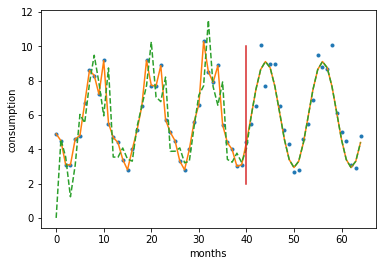

In [31]:
# The data 
plt.plot(y[0, :], '.')

# The posterior/predictive mean
pred_mean = np.matmul(H, mp)[0, :]
plt.plot(np.matmul(H, mu)[0, :], '-')
plt.plot(pred_mean, '--')

# Vertical line showing where forecasting starts
plt.plot([n-delta-1, n-delta-1], [2, 10])
plt.xlabel('months')
plt.ylabel('consumption');

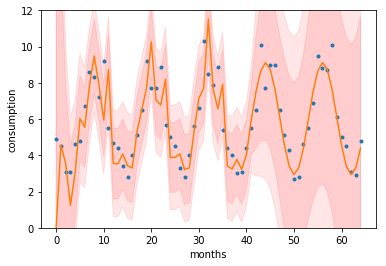

In [32]:
# The data 
plt.plot(y[0, :], '.')

# The posterior/predictive mean
plt.plot(pred_mean, '-');

# Compute the posterior/predicted standard deviation 
pred_std_dev = np.zeros(n)
for k in range(n):
    pred_std_dev[k] = np.sqrt(np.matmul(np.matmul(H, Pp[:, :, k]), H.T) + V)

# The uncertainty
for i in range(2,4):
    plt.fill_between(np.linspace(0,n-1,n),
                 y1=pred_mean-i*pred_std_dev,
                 y2=pred_mean+i*pred_std_dev, color='r', alpha=.1)
plt.xlabel('months')
plt.ylabel('consumption')
axes = plt.gca()
axes.set_ylim([0,12]);

### Distribution of the error

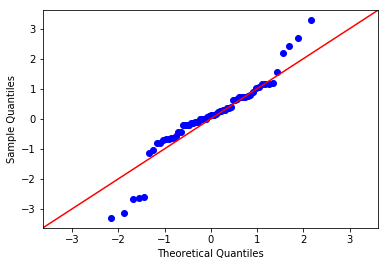

In [33]:
sm.qqplot(err0, line='45')
pylab.show()

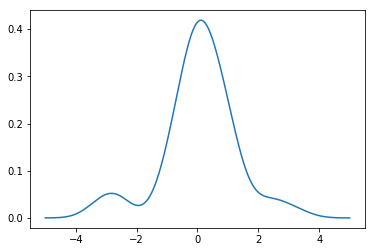

In [45]:
plot_density(err0, 0.5)

## A more complex model

In [35]:
# Superposition of a first-order model and a more complex Fourier-form seasonal model
F = block_diag(1, rotation_mat(omega), rotation_mat(2*omega), rotation_mat(3*omega), rotation_mat(4*omega),rotation_mat(5*omega))
H = np.array([[1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]])

d = 11
# Uninformative prior (large covariance)
m0 = np.zeros(d)
m0[0] = 6
P0 = 10 * np.eye(d) # np.eye(d) is the identity matrix of dimension d

# Less noise is required as the model is more accurate
U = 0.005 * np.eye(d)

### Filtering

In [36]:
# We try to predict the last 24 time steps (2 years)
delta = 0
(mp, Pp, mu, Pu, ml1, err1) = Kalman_filter(y, m0, P0, F, H, U, V, n, d, delta)

### Plot of the results

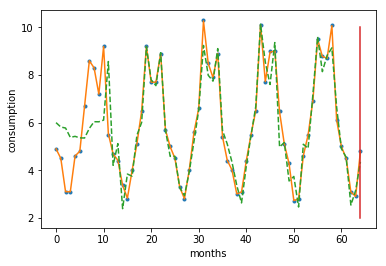

In [37]:
# The data 
plt.plot(y[0, :], '.')
# The posterior/predictive mean
pred_mean = np.matmul(H, mp)[0, :]
plt.plot(np.matmul(H, mu)[0, :], '-');
plt.plot(pred_mean, '--');
# Vertical line showing where forecasting starts
plt.plot([n-delta-1, n-delta-1], [2, 10])
plt.xlabel('months')
plt.ylabel('consumption');

We would like to check how certain we are of our forcast

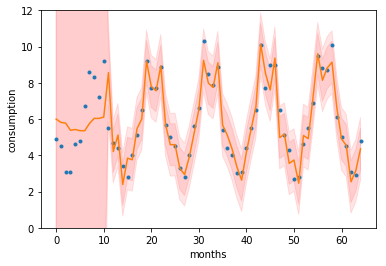

In [38]:
# The data 
plt.plot(y[0, :], '.')

# The posterior/predictive mean
plt.plot(pred_mean, '-');

# Compute the posterior/predicted standard deviation 
pred_std_dev = np.zeros(n)
for k in range(n):
    pred_std_dev[k] = np.sqrt(np.matmul(np.matmul(H, Pp[:, :, k]), H.T) + V)

# The uncertainty
for i in range(2,4):
    plt.fill_between(np.linspace(0,n-1,n),
                 y1=pred_mean-i*pred_std_dev,
                 y2=pred_mean+i*pred_std_dev, color='r', alpha=.1)
plt.xlabel('months')
plt.ylabel('consumption')
axes = plt.gca()
axes.set_ylim([0,12]);

### Distribution of the error

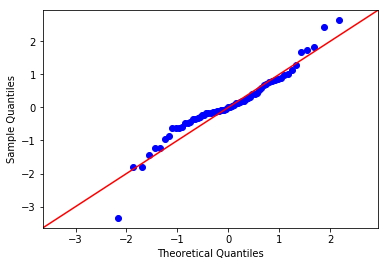

In [42]:
sm.qqplot(err1, line='45')
pylab.show()

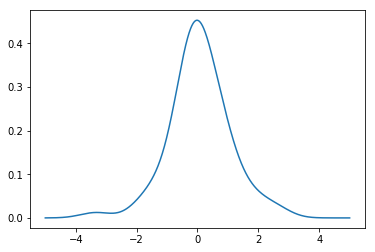

In [44]:
plot_density(err1, 0.5)

### Bayes Factor

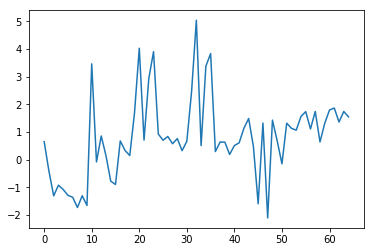

In [49]:
# Comparing the first and second models
Bayes_factor = np.zeros(n)
Bayes_factor[:n-delta] = ml1[:n-delta] / ml0[:n-delta]
plt.plot(np.log(Bayes_factor));

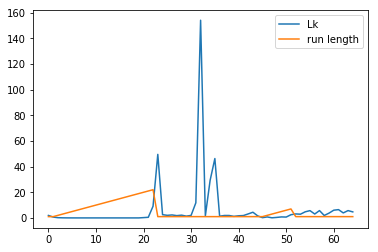

In [50]:
(Lk, run_length) = model_comparison(Bayes_factor, n)

plt.plot(Lk, label='Lk')
plt.plot(run_length, label='run length')
plt.legend()
axes = plt.gca();
#axes.set_ylim([0,10]);

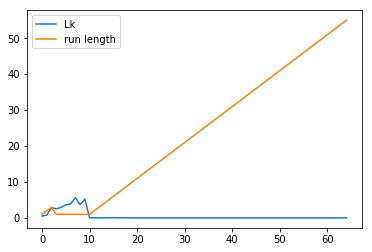

In [51]:
(Lk, run_length) = model_comparison(1/Bayes_factor, n)

plt.plot(Lk, label='Lk')
plt.plot(run_length, label='run length')
plt.legend();

Let's look at the individual components

In [ ]:
# Loop on the different components of the state
for comp in range(11):
    plt.figure()
    pred_mean = mu[comp, :]
    pred_std_dev = np.zeros(n)
    for k in range(n):
        pred_std_dev[k] = np.sqrt(Pu[comp, comp, k])

    # The posterior/predictive mean
    plt.plot(pred_mean, '-');

    # The uncertainty
    for i in range(2,4):
        plt.fill_between(np.linspace(0,n-1,n),
                     y1=pred_mean-i*pred_std_dev,
                     y2=pred_mean+i*pred_std_dev, color='r', alpha=.1)
        plt.xlabel('months')
        plt.ylabel('consumption')
        plt.title('Component '+str(comp))


It appears in figures above that the components 3 to 6 (corresponding to $2\omega$ and $3\omega$) do not contribute much to the estimate, so we can try to remove them

## A simpler (but not too simple) model

In [54]:
# Superposition of a first-order model and a simpler Fourier-form seasonal model
F = block_diag(1, rotation_mat(omega), rotation_mat(4*omega))
H = np.array([[1, 1, 0, 1, 0]])

d = 5
# Uninformative prior (large covariance)
m0 = np.zeros(d)
P0 = 100 * np.eye(d) # np.eye(d) is the identity matrix of dimension d

# Less noise is required as the model is more accurate
U = 0.05 * np.eye(d)

### Filtering

In [56]:
# We try to predict the last 24 time steps (2 years)
delta = 0
(mp, Pp, mu, Pu, ml2, err2) = Kalman_filter(y, m0, P0, F, H, U, V, n, d, delta)

### Plot of the results

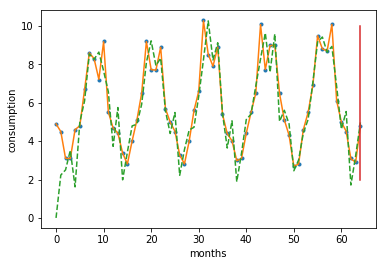

In [57]:
# The data 
plt.plot(y[0, :], '.')
# The posterior/predictive mean
pred_mean = np.matmul(H, mp)[0, :]
plt.plot(np.matmul(H, mu)[0, :], '-');
plt.plot(pred_mean, '--');
# Vertical line showing where forecasting starts
plt.plot([n-delta-1, n-delta-1], [2, 10])
plt.xlabel('months')
plt.ylabel('consumption');

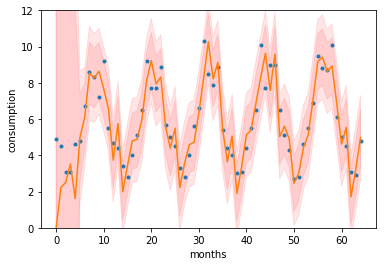

In [60]:
# The data 
plt.plot(y[0, :], '.')

# The posterior/predictive mean
plt.plot(pred_mean, '-');

# Compute the posterior/predicted standard deviation 
pred_std_dev = np.zeros(n)
for k in range(n):
    pred_std_dev[k] = np.sqrt(np.matmul(np.matmul(H, Pp[:, :, k]), H.T) + V)

# The uncertainty
for i in range(2,4):
    plt.fill_between(np.linspace(0,n-1,n),
                 y1=pred_mean-i*pred_std_dev,
                 y2=pred_mean+i*pred_std_dev, color='r', alpha=.1)
plt.xlabel('months')
plt.ylabel('consumption')
axes = plt.gca()
axes.set_ylim([0,12]);

### Distribution of the error

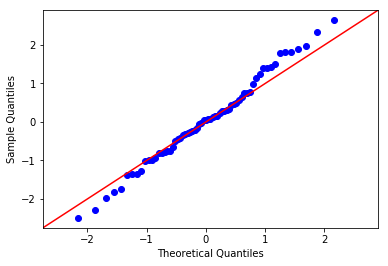

In [61]:
sm.qqplot(err2, line='45')
pylab.show()

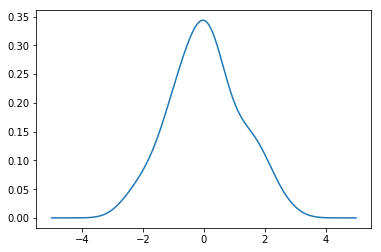

In [63]:
plot_density(err2, 0.5)

### Bayes Factor

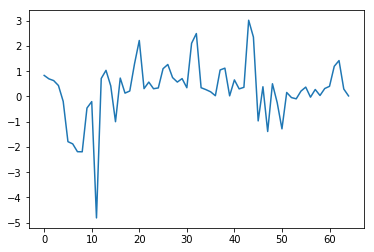

In [64]:
# Comparing the second and third models
Bayes_factor = np.zeros(n)
Bayes_factor[:n-delta] = ml1[:n-delta] / ml2[:n-delta]
plt.plot(np.log(Bayes_factor));

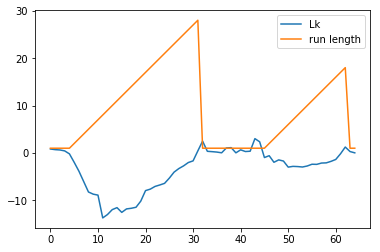

In [65]:
(Lk, run_length) = model_comparison(Bayes_factor, n)

plt.plot(np.log(Lk), label='Lk')
plt.plot(run_length, label='run length')
plt.legend();

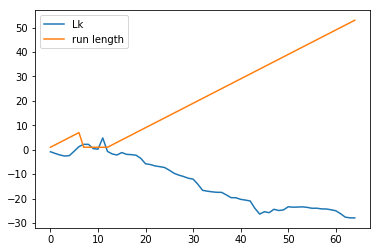

In [66]:
(Lk, run_length) = model_comparison(1/Bayes_factor, n)
plt.plot(np.log(Lk), label='Lk')
plt.plot(run_length, label='run length')
plt.legend()

# New data

In [67]:
def general_Kalman_filter(y, m0, P0, F, H, U, V, c, n, xdim, delta):
    # y       data array (dim d' x N with N the total number of data points)
    # m0      prior mean (dim d)
    # P0      prior variance (dim d x d)
    # F       transition matrix (dim d x d x n)
    # H       observation matrix (dim d' x d x n)
    # U       transition noise covariance (dim d x d x n)
    # V       observatiion noise variance (dim d' x d' x n)
    # c       control variable (dim d x n)
    # n       number of time steps to be processed
    # xdim    dimension of the state (same as d)
    # delta   number of predictive time steps (last observation used n - delta - 1)
    
    mu = np.zeros((xdim, n))
    Pu = np.zeros((xdim, xdim, n))
    mp = np.zeros((xdim, n))
    Pp = np.zeros((xdim, xdim, n))
    mp[:, 0] = m0
    Pp[:, :, 0] = P0
    marg_like = np.zeros(n)
    err = np.zeros(n)
    for k in range(n):
        z = y[:, k] - np.matmul(H[:, :, k], mp[:, k])
        S = np.matmul(np.matmul(H[:, :, k], Pp[:, :, k]), H[:, :, k].transpose()) + V[:, :, k]
        marg_like[k] = normal_pdf(z, 0.0, S)
        err[k] = z / np.sqrt(S)
        if k < n - delta:
            # Update
            K = np.matmul(np.matmul(Pp[:, :, k], H[:, :, k].transpose()), inv(S))
            mu[:, k] = mp[:, k] + np.matmul(K, z)
            Pu[:, :, k] = np.matmul(np.eye(xdim) - np.matmul(K, H[:, :, k]), Pp[:, :, k])
        else:
            mu[:, k] = mp[:, k]
            Pu[:, :, k] = Pp[:, :, k]
        
        if k < n-1:
            # Prediction
            mp[:, k+1] = np.matmul(F[:, :, k+1], mu[:, k])
            Pp[:, :, k+1] = np.matmul(np.matmul(F[:, :, k+1], Pu[:, :, k]), F[:, :, k+1].transpose()) + c[:, k+1] + U[:, :, k+1]
    return mp, Pp, mu, Pu

In [68]:
# Change the data for the purpose of demonstrating intervention
yy = np.zeros((1, n))
k_change = 37
yy[0, :k_change] = y[0, :k_change]
yy[0, k_change:] = y[0, k_change:]/2

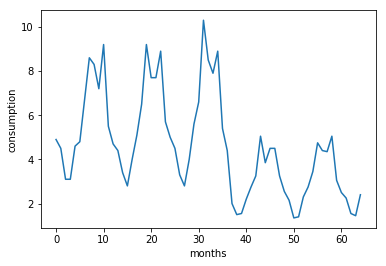

In [69]:
# Plot the new data
plt.plot(yy[0, :])
plt.xlabel('months')
plt.ylabel('consumption');

### The simple model again

In [70]:
# Superposition of a first-order model and a simple Fourier-form seasonal model
Fk = block_diag(1, rotation_mat(omega))
Hk = np.array([[1, 1, 0]])

d = 3
# Uninformative prior (large covariance)
m0 = np.zeros(d)
P0 = 100*np.eye(d) # np.eye(d) is the identity matrix of dimension d

# The first-order model does not evolve much but the are changes in the cycles
Uk = np.array([[0.05, 0 , 0], [0, .5, 0],[0, 0, .5]])
Vk = 0.01 * np.eye(1)

c = np.zeros((d, n))
F = np.zeros((d, d, n))
H = np.zeros((1, d, n))
U = np.zeros((d, d, n))
V = np.zeros((1, 1, n))
for k in range(n):
    F[:, :, k] = Fk
    H[:, :, k] = Hk
    U[:, :, k] = Uk
    V[:, :, k] = Vk

### Filtering up to k_change

In [71]:
# Run the Kalman filter up to the time of change
(mp, Pp, mu, Pu) = general_Kalman_filter(yy, m0, P0, F, H, U, V, c, k_change+1, d, 0)

In [72]:
# New mean and variance at time of change
k = k_change
m_change = mp[:, k]/2
P_change = Pp[:, :, k]/4

# Cholesky decompositions
Lk = cholesky(Pp[:, :, k])
Lk_change = cholesky(P_change)

Mk = np.matmul(Lk_change, inv(Lk))

F[:, :, k] = np.matmul(Mk, Fk)
c[:, k] = m_change - np.matmul(F[:, :, k], mu[:, k-1])
U[:, :, k] = np.matmul(np.matmul(Mk, U[:, :, k]), Mk.transpose())

In [73]:
# Run the Kalman filter with the new model
delta = n-k_change
(mp, Pp, mu, Pu) = general_Kalman_filter(yy, m0, P0, F, H, U, V, c, n, d, delta)

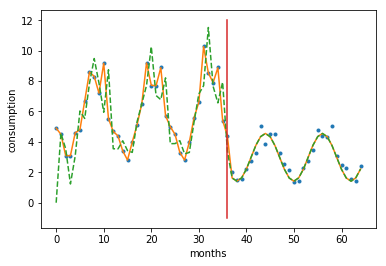

In [74]:
# The data 
plt.plot(yy[0, :], '.')
# The posterior/predictive mean
pred_mean = np.matmul(Hk, mp)[0, :]
plt.plot(np.matmul(Hk, mu)[0, :], '-');
plt.plot(pred_mean, '--');
# Vertical line showing where forecasting starts
plt.plot([n-delta-1, n-delta-1], [-1, 12])
plt.xlabel('months')
plt.ylabel('consumption');

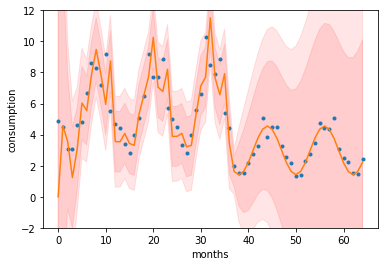

In [75]:
# The data 
plt.plot(yy[0, :], '.')

# The posterior/predictive mean
plt.plot(pred_mean, '-');

# Compute the posterior/predicted standard deviation 
pred_std_dev = np.zeros(n)
for k in range(n):
    pred_std_dev[k] = np.sqrt(np.matmul(np.matmul(Hk, Pp[:, :, k]), Hk.T) + Vk)

# The uncertainty
for i in range(2,4):
    plt.fill_between(np.linspace(0,n-1,n),
                 y1=pred_mean-i*pred_std_dev,
                 y2=pred_mean+i*pred_std_dev, color='r', alpha=.1)
plt.xlabel('months')
plt.ylabel('consumption')
axes = plt.gca()
axes.set_ylim([-2,12]);